In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from IPython.display import clear_output
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# core MAGI-TFP class
import magi_v2

/local/scratch/sxxiao/magi_v2/magi_v2.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from scipy.special import kvp, gamma
import tf_keras
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
from typing import Union, Callable
import time
from tqdm.autonotebook import tqdm


# Governing Equations for the SEIR System

We begin by encoding the [governing ODE equations for the SEIR system](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) into a broadcastable form for compatibility with TensorFlow Probability vectorization. We reduce the degrees of the freedom by noting that $S$ is a deterministic function of $E, I, R$: namely, $S = 1 - E - I - R$, if we let $S,E,I,R$ represent the proportions of the population in each compartment.

In [5]:
# 3-component model governing the SEIR system, appropriate for tensorflow vectorization

#def f_vec(t, X, thetas):
#    '''
#    1. X - array containing (E, I, R) components. Suppose it is (N x D) for vectorization.
#    2. theta - array containing (beta, gamma, sigma) components.
#    3. Note that N_pop = 1.0, and that S is deterministic: S = 1 - (E + I + R)
#    '''
#    # implicitly compute S
#    S = 1.0 - tf.reshape(tf.reduce_sum(X, axis=1), shape=(-1, 1))
#    return tf.concat([(thetas[0] * S * X[:,1:2]) - (thetas[2] * X[:,0:1]), # dE/dt = bSI - sE
#                      (thetas[2] * X[:,0:1]) - (thetas[1] * X[:,1:2]), # dI/dt = sE - gI
#                      (thetas[1] * X[:,1:2])], # dR/dt = g*I
#                     axis=1)



# 4-component model governing the SIRW system, appropriate for tensorflow vectorization
def f_vec(t, X, thetas):
    """
    Computes the time derivative of the SIRW model components.

    Args:
        t: Time (not used in this function, but present for consistency in ODE frameworks).
        X: Tensor of shape (N, 4), containing (S, I, R, W) components.
        thetas: Tensor of shape (5,), containing model parameters (beta, phi, xi, chi, kappa).
    
    Returns:
        Tensor of shape (N, 4), the time derivatives of (S, I, R, W).
    """
    # Extract individual components from the state vector
    S, I, R, W = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    beta, phi, xi, chi, kappa = thetas

    # Compute the derivatives
    dS_dt = -beta * S * I + kappa * W           # dS/dt = -beta * S * I + kappa * W
    dI_dt = beta * S * I - phi * I              # dI/dt = beta * S * I - phi * I
    dR_dt = phi * I - xi * R + chi * I * W      # dR/dt = phi * I - xi * R + chi * I * W
    dW_dt = xi * R - chi * I * W - kappa * W    # dW/dt = xi * R - chi * I * W - kappa * W

    # Concatenate derivatives into a single tensor
    return tf.concat([dS_dt, 
                      dI_dt, 
                      dR_dt, 
                      dW_dt], axis=1)


# Loading in our Dataset and Simulating Missingness

Below, we load in ground truth and noisy observation datasets.

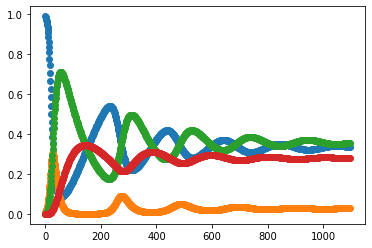

In [21]:
# load in our data, thinning based on density of observations
raw_data = pd.read_csv(f"/local/scratch/sxxiao/GP-SIR-Experiments/Experiment_3_SIRW/data/sirw_endemic_beta0.3_phi0.1_xi0.01_chi0.1_kappa0.01_clean.csv")

plt.scatter(raw_data["t"], raw_data["S"])
plt.scatter(raw_data["t"], raw_data["I"])
plt.scatter(raw_data["t"], raw_data["R"])
plt.scatter(raw_data["t"], raw_data["W"])


In [23]:
# initial data settings
d_obs = 1 # no. of observations per unit time
t_max = 3 * 365 # we have observations from T=0 to T= 3 * 365.
comp_obs = [True, True, True, True] # which components are observed? Here, everything is observed.


obs_data = raw_data.iloc[::int((raw_data.index.shape[0] - 1) / (d_obs * t_max))]

# extract out the time vector + noisy observations
ts_obs = obs_data.t.values.astype(np.float64)

# 11/18/2024 - let's try using the truth instead of _obs
X_obs = obs_data[["S", "I", "R", "W"]].to_numpy().astype(np.float64) # S is implicit!
X_obs[X_obs < 0.0] = 0.0 # we know SEIR must be between [0, 1]

# make certain components missing if necessary
for i, comp_obs_val in enumerate(comp_obs):
    if comp_obs_val != True:
        X_obs[:,i] = np.nan

# MAGI Model Fitting

Next, in just four lines of code modeled after `scikit-learn`'s syntax, we a) instantiate our MAGI model, b) fit the Matern kernel hyperparameters and other initial values for observed and unobserved components, and c) perform inference via [NUTS](https://arxiv.org/abs/1111.4246) sampling on the posterior distribution.

In [ ]:
# create our model - f_vec is the ODE governing equations function defined earlier.
model = magi_v2.MAGI_v2(D_thetas=3, ts_obs=ts_obs, X_obs=X_obs, bandsize=200, f_vec=f_vec)

# fit Matern kernel hyperparameters (phi1, phi2) as well as (Xhat_init, sigma_sqs_init, thetas_init)
model.initial_fit(discretization=1, verbose=True)

# clear console for pretty output
clear_output(wait=True)



Fitting hparams for 4 components:   0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


In [17]:
# collect our samples from NUTS posterior sampling
results = model.predict(num_results=1000, num_burnin_steps=1000, verbose=True)

Starting NUTS posterior sampling ...


InvalidArgumentError: Trying to access resource Variable/51 (defined @ /local/scratch/sxxiao/magi_v2/magi_v2.py:841) located in device /job:localhost/replica:0/task:0/device:CPU:0 from device /job:localhost/replica:0/task:0/device:GPU:0
 Cf. https://www.tensorflow.org/xla/known_issues#tfvariable_on_a_different_device [Op:__inference_run_nuts_127725]

# Checking Results

Below, we visualize the inferred trajectories from our NUTS posterior samples by plotting the mean predicted trajectories and the 95% predictive intervals against the ground truth and our noisy observations. Subplots without noisy observations scatter-plotted indicate that this component was simulated as completely missing during the model training process.

Below we also check our mean inferred parameter values $\hat{\theta}$ vs. their true values.

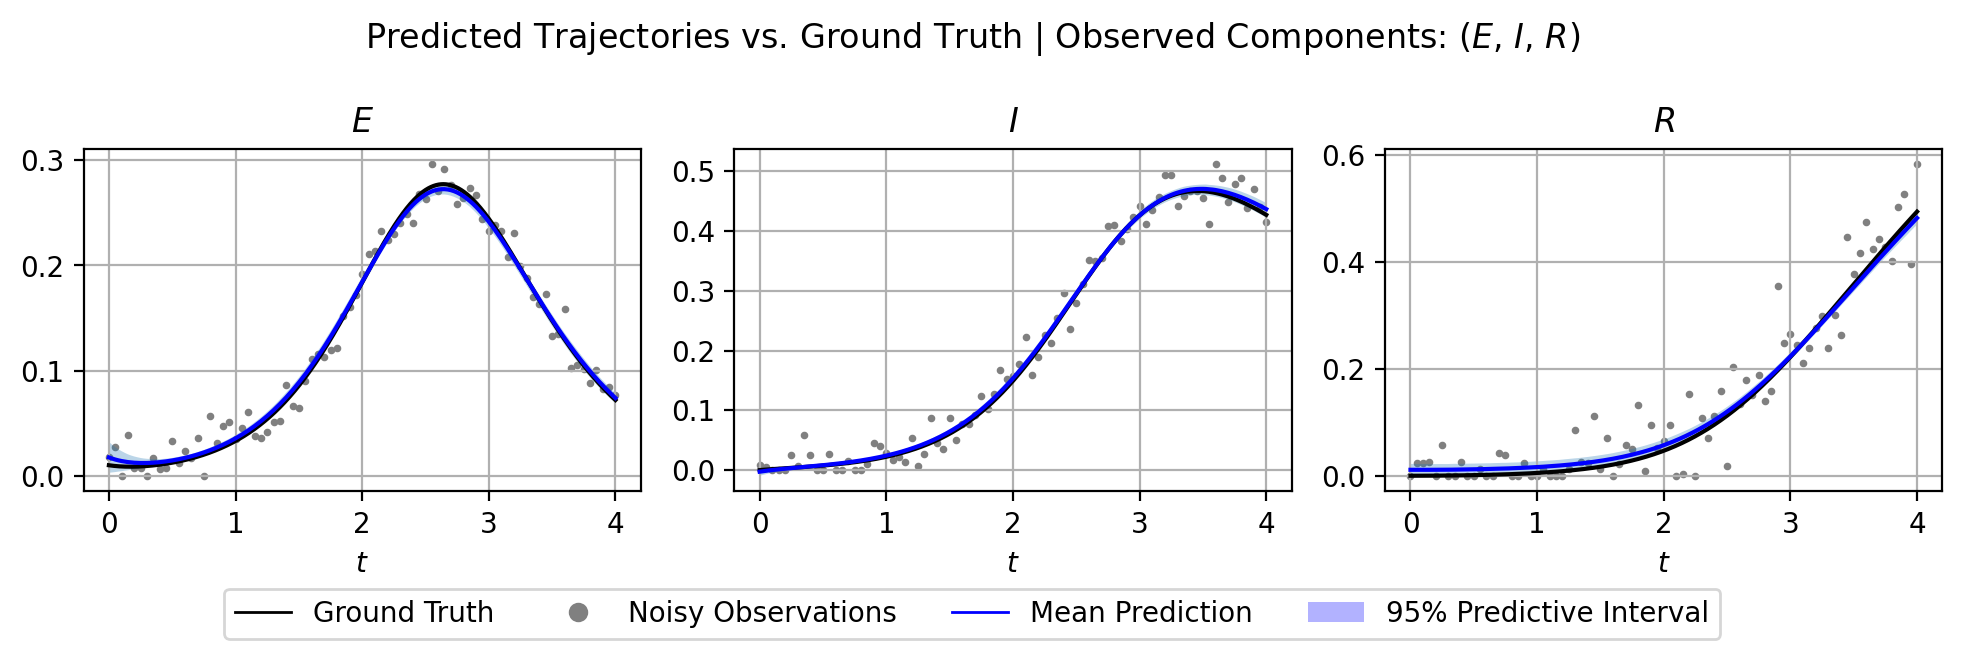

In [5]:
# visualize our trajectories
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(10, 3))

# get our timesteps, mean trajectory predictions, and 2.5% + 97.5% trajectory predictions
I = results["I"].flatten()
Xhat_means = results["X_samps"].mean(axis=0)
Xhat_intervals = np.quantile(results["X_samps"], q=[0.025, 0.975], axis=0)

# go through each component and plot
for i, comp in enumerate(["$E$", "$I$", "$R$"]):
    
    # plot the ground truth + noisy observations
    if comp_obs[i]:
        ax[i].scatter(ts_obs, X_obs[:,i], s=3, color="grey")
    ax[i].plot(raw_data["t"], raw_data[["E_true", "I_true", "R_true"][i]], color="black")
    
    # plot mean trajectory + 95% predictive interval
    ax[i].plot(I, Xhat_means[:,i], color="blue")
    ax[i].fill_between(I, Xhat_intervals[0,:,i], Xhat_intervals[1,:,i], alpha=0.3)
    ax[i].set_title(comp); ax[i].set_xlabel("$t$")
    ax[i].grid()
    
# shared legend + beautify
observed_components_desc = str(tuple(np.array(["$E$", "$I$", "$R$"])[comp_obs])).replace("'", "").strip()
plt.suptitle(f"Predicted Trajectories vs. Ground Truth | Observed Components: {observed_components_desc}")
custom_lines = [Line2D([0], [0], color="black", linewidth=1.0, alpha=1.0, label="Ground Truth"),
                Line2D([0], [0], color="grey", marker="o", linestyle="None", label="Noisy Observations"),
                Line2D([0], [0], color="blue", linewidth=1.0, alpha=1.0, label="Mean Prediction"),
                Patch(facecolor="blue", alpha=0.3, label="95% Predictive Interval")]
fig.legend(handles=custom_lines, loc="lower center", ncol=4, fontsize=10, bbox_to_anchor=(0.5, -0.075))
plt.tight_layout()
plt.show()

In [6]:
# check our parameters too
mean_thetas_pred = results["thetas_samps"].mean(axis=0)

print("Estimated Parameters:")
print(f"- Beta: {np.round(mean_thetas_pred[0], 3)} (Predicted) vs. 6.0 (Actual).")
print(f"- Gamma: {np.round(mean_thetas_pred[1], 3)} (Predicted) vs. 0.6 (Actual).")
print(f"- Sigma: {np.round(mean_thetas_pred[2], 3)} (Predicted) vs. 1.8 (Actual).")

Estimated Parameters:
- Beta: 5.831 (Predicted) vs. 6.0 (Actual).
- Gamma: 0.565 (Predicted) vs. 0.6 (Actual).
- Sigma: 1.77 (Predicted) vs. 1.8 (Actual).
